### **Mount the drive**


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import pandas as pd
import math

from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
# Data Souce - https://jstagedata.jst.go.jp/articles/dataset/Training_images_for_semantic_segmentation_of_bridge_damage_detection/24750210

### **Images from 5 different damage classes**

In [ ]:
# Load the dataset
spalling_path = '/content/drive/MyDrive/Project_02/spalling'
leaking_path = '/content/drive/MyDrive/Project_02/leaking'
freelime_path = '/content/drive/MyDrive/Project_02/free_lime'
crack_path = '/content/drive/MyDrive/Project_02/cracks'
corrosion_path = '/content/drive/MyDrive/Project_02/corrosion'

spalling_path_list = os.listdir(spalling_path)
leaking_path_list = os.listdir(leaking_path)
freelime_path_list = os.listdir(freelime_path)
crack_path_list = os.listdir(crack_path)
corrosion_path_list = os.listdir(corrosion_path)

In [ ]:
from PIL import Image
import glob

data = []

# Iterate through the files in the first folder
for file_path in glob.glob(os.path.join(spalling_path, '*.png')):
    # Load the image data from the file using Pillow
    img = Image.open(file_path)
    img = img.resize((100, 100))

    # Convert PIL Image to numpy array
    img_array = np.array(img)
    label = 'spalling'
    data.append((img_array, label))

In [ ]:
# Iterate through the files in the first folder
for file_path in glob.glob(os.path.join(leaking_path, '*.png')):
    # Load the image data from the file using Pillow
    img = Image.open(file_path)
    img = img.resize((100, 100))

    # Convert PIL Image to numpy array
    img_array = np.array(img)
    label = 'leaking'
    data.append((img_array, label))

In [ ]:
# Iterate through the files in the first folder
for file_path in glob.glob(os.path.join(freelime_path, '*.png')):
    # Load the image data from the file using Pillow
    img = Image.open(file_path)
    img = img.resize((100, 100))

    # Convert PIL Image to numpy array
    img_array = np.array(img)
    label = 'freelime'
    data.append((img_array, label))

In [ ]:
# Iterate through the files in the first folder
for file_path in glob.glob(os.path.join(crack_path, '*.png')):
    # Load the image data from the file using Pillow
    img = Image.open(file_path)
    img = img.resize((100, 100))

    # Convert PIL Image to numpy array
    img_array = np.array(img)
    label = 'crack'
    data.append((img_array, label))

In [ ]:
# Iterate through the files in the first folder
for file_path in glob.glob(os.path.join(corrosion_path, '*.png')):
    # Load the image data from the file using Pillow
    img = Image.open(file_path)
    img = img.resize((100, 100))

    # Convert PIL Image to numpy array
    img_array = np.array(img)
    label = 'corrosion'
    data.append((img_array, label))

### **Bridge Damage Detection using Single Shot Detectors (SSD)**

In [ ]:
# Shuffle the data and split into train/test sets
random.seed(42)
data = [(tensor, label) for tensor, label in data if tensor.shape[-1] != 4]
random.shuffle(data)
train_data, test_data = data[:int(len(data) * 0.7)], data[int(len(data) * 0.7):]

In [ ]:
print('Training dataset: ', len(train_data))
print('Training dataset: ', len(test_data))

Training dataset:  1676
Training dataset:  719


In [ ]:
# Reshape the data
X_train, Y_train = zip(*train_data)
X_test, Y_test = zip(*test_data)
X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)
Y_test = np.array(Y_test)

In [ ]:
# Change integers to 32-bit floating point numbers
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# normalize each value for each pixel
X_train /= 255
X_test /= 255

In [ ]:
# Encoding
categories = np.array(['spalling' , 'leaking' , 'freelime' , 'crack' , 'corrosion'])
category_map = {'spalling': 0, 'leaking': 1, 'freelime': 2, 'crack': 3, 'corrosion': 4}
Y_train = np.array([category_map[category] for category in Y_train])
Y_test = np.array([category_map[category] for category in Y_test])

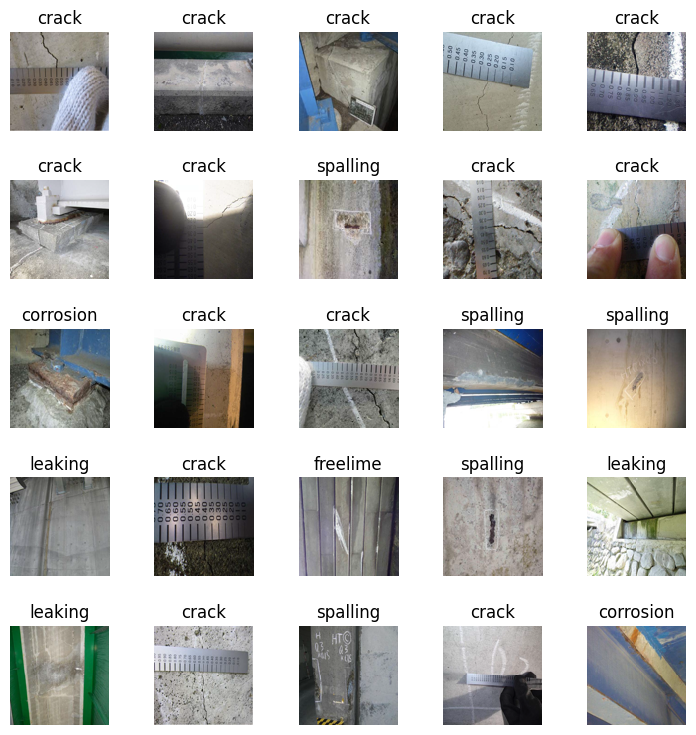

In [ ]:
plt.rcParams['figure.figsize'] = (9, 9)

labels = ['spalling', 'leaking', 'freelime', 'crack', 'corrosion']

fig, axes = plt.subplots(5, 5, figsize=(9, 9))
fig.subplots_adjust(hspace=0.5)

for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i], interpolation='none')
    ax.set_title("{}".format(labels[int(Y_train[i])]))
    ax.axis('off')

plt.show()


### **SSD Model**

In [ ]:
img_rows, img_cols = 100, 100
channels = 3

In [ ]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

seed_value = 1234
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
random.seed(seed_value)

In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense

def ssd_model(input_shape=(img_rows, img_cols, channels), num_classes=5):
    # Input layer
    input_tensor = Input(shape=input_shape)

    # Feature extraction
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_tensor)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(100, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)

    # Flatten
    x = Flatten()(x)

    # Fully connected layers for classification
    x = Dense(256, activation='relu')(x)
    x = Dense(128, activation='relu')(x)

    # Output layer for classification
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input_tensor, outputs=output)
    model.summary()

    return model

In [ ]:
# Replace img_rows, img_cols, and channels with the actual dimensions of your images.
img_rows, img_cols, channels = 100, 100, 3

# Create the SSD model
ssd_model = ssd_model(input_shape=(img_rows, img_cols, channels), num_classes=5)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 50, 50, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 100)       28900     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 25, 25, 100)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 128)       115328

In [ ]:
model = ssd_model

In [ ]:
# pip install visualkeras

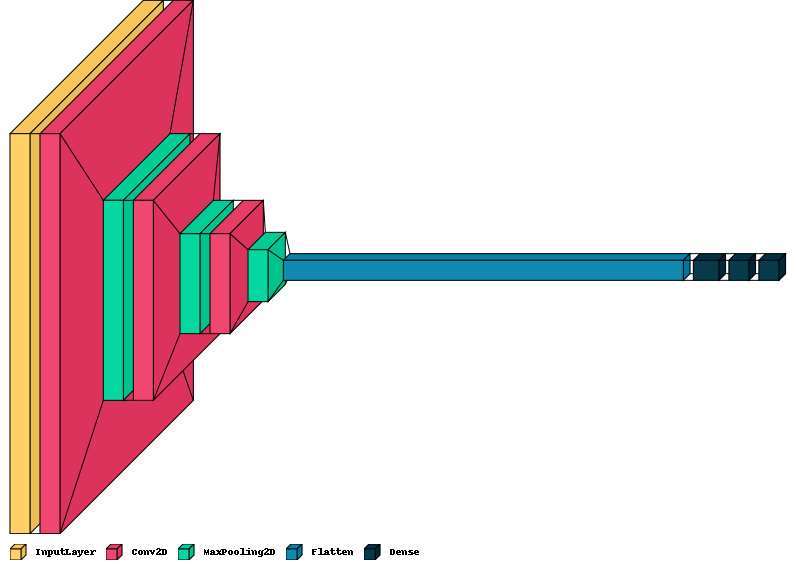

In [ ]:
import visualkeras
from PIL import ImageFont

visualkeras.layered_view(model).show() # display using your system viewer
visualkeras.layered_view(model)
visualkeras.layered_view(model, legend=True)

In [ ]:
y_train = to_categorical(Y_train, 5)
y_test = to_categorical(Y_test, 5)

Model Building

In [ ]:
# Compile the model
model.compile(loss=['categorical_crossentropy', 'mse'],
                  optimizer='adam',
                  metrics=['accuracy'])

In [ ]:
hist = model.fit(X_train, y_train,
      batch_size=128,
      epochs=50,
      verbose=2,
      validation_data=(X_test, y_test))

Epoch 1/50
14/14 - 132s - loss: 1.4947 - accuracy: 0.2947 - val_loss: 1.4105 - val_accuracy: 0.3213 - 132s/epoch - 9s/step
Epoch 2/50
14/14 - 66s - loss: 1.4074 - accuracy: 0.3329 - val_loss: 1.3620 - val_accuracy: 0.3408 - 66s/epoch - 5s/step
Epoch 3/50
14/14 - 63s - loss: 1.2587 - accuracy: 0.4654 - val_loss: 1.2320 - val_accuracy: 0.4673 - 63s/epoch - 4s/step
Epoch 4/50
14/14 - 66s - loss: 1.1532 - accuracy: 0.5036 - val_loss: 1.2672 - val_accuracy: 0.4520 - 66s/epoch - 5s/step
Epoch 5/50
14/14 - 65s - loss: 1.0832 - accuracy: 0.5662 - val_loss: 1.2181 - val_accuracy: 0.4896 - 65s/epoch - 5s/step
Epoch 6/50
14/14 - 64s - loss: 0.9890 - accuracy: 0.6020 - val_loss: 1.0484 - val_accuracy: 0.5994 - 64s/epoch - 5s/step
Epoch 7/50
14/14 - 64s - loss: 0.8966 - accuracy: 0.6724 - val_loss: 1.0470 - val_accuracy: 0.5828 - 64s/epoch - 5s/step
Epoch 8/50
14/14 - 64s - loss: 0.8136 - accuracy: 0.6885 - val_loss: 1.0458 - val_accuracy: 0.6106 - 64s/epoch - 5s/step
Epoch 9/50
14/14 - 64s - loss:

Evaluate the model

In [ ]:
from sklearn.metrics import accuracy_score

# Predictions on training data
y_train_pred = model.predict(X_train)
train_loss = model.evaluate(X_train, y_train, verbose=0)[0]
train_accuracy = accuracy_score(np.argmax(y_train, axis=1), np.argmax(y_train_pred, axis=1))

print('Train loss:', round(train_loss, 4))
print('Train accuracy:', round(train_accuracy, 4), '\n')

# Predictions on test data
y_test_pred = model.predict(X_test)
test_loss = model.evaluate(X_test, y_test, verbose=0)[0]
test_accuracy = accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_test_pred, axis=1))

print('Test loss:', round(test_loss, 4))
print('Test accuracy:', round(test_accuracy, 4))

53/53 [==============================] - 16s 300ms/step
Train loss: 0.0003
Train accuracy: 1.0 

23/23 [==============================] - 9s 375ms/step
Test loss: 3.5584
Test accuracy: 0.6704


In [ ]:
from sklearn.metrics import classification_report, cohen_kappa_score

# Make predictions on the test set
y_pred = model.predict(X_test)

# Convert the predicted labels to multiclass format
y_pred_multiclass = np.argmax(y_pred, axis=1)
y_test_multiclass = np.argmax(y_test, axis=1)

# Calculate the kappa score
kappa = cohen_kappa_score(y_test_multiclass, y_pred_multiclass)
print("The result of Kappa is:", round(kappa, 3))

# Generate the classification report
report = classification_report(y_test_multiclass, y_pred_multiclass, target_names=labels)

# Print the report
print("The result of the classification report is:\n", report)


23/23 [==============================] - 6s 259ms/step
The result of Kappa is: 0.548
The result of the classification report is:
               precision    recall  f1-score   support

    spalling       0.62      0.68      0.65       230
     leaking       0.66      0.60      0.63       161
    freelime       0.50      0.29      0.36        21
       crack       0.76      0.79      0.78       222
   corrosion       0.61      0.56      0.59        85

    accuracy                           0.67       719
   macro avg       0.63      0.58      0.60       719
weighted avg       0.67      0.67      0.67       719



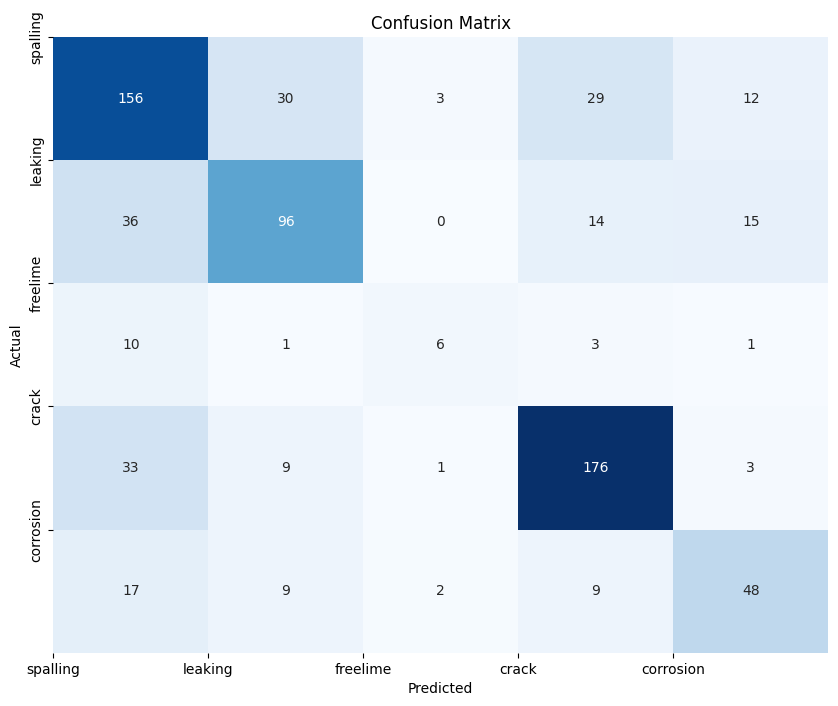

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
# from sklearn.metrics import plot_confusion_matrix

# Calculate the confusion matrix
cm = confusion_matrix(y_test_multiclass, y_pred_multiclass)

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the confusion matrix with seaborn
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)

# Set labels, title, and ticks
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.xticks(ticks=range(len(labels)), labels=labels)
plt.yticks(ticks=range(len(labels)), labels=labels)

# Display the plot
plt.show()


#### Predictions

1/1 [==============================] - 0s 426ms/step


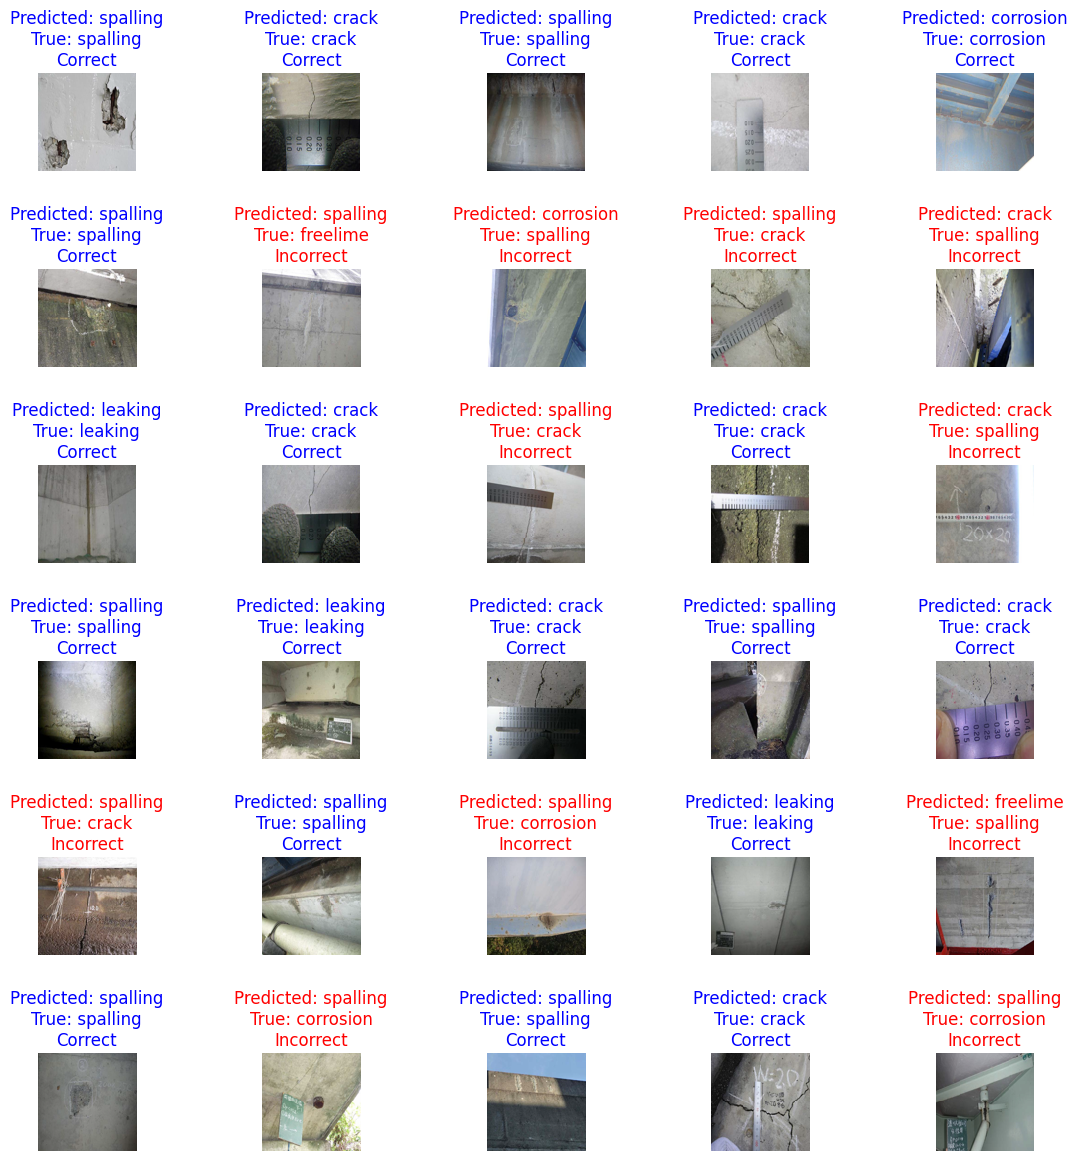

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_images_with_predictions(images, figsize=(12, 12), columns=1, interpolate=False, image_titles=None):
    if type(images[0]) is np.ndarray:
        if images.shape[-1] != 3:
            images = images[:, :, :, 0]
    fig = plt.figure(figsize=figsize)
    rows = len(images) // columns if len(images) % columns == 0 else len(images) // columns + 1

    # Add some gap between rows
    fig.subplots_adjust(hspace=1)

    for i in range(len(images)):
        subplot = fig.add_subplot(rows, columns, i + 1)
        subplot.axis('Off')
        if image_titles is not None:
            subplot.set_title(image_titles[i], fontsize=12, color='blue' if 'Correct' in image_titles[i] else 'red')
        plt.imshow(images[i], interpolation=None if interpolate else 'none')

image_range = range(30)
sample_images = X_test[image_range]
true_labels = [labels[np.argmax(x)] for x in y_test[image_range]]
predictions = model.predict(sample_images.reshape(len(image_range), img_rows, img_cols, channels))
predicted_labels = [labels[np.argmax(x)] for x in predictions]

# Change the format of titles based on prediction correctness
titles = [
    f"Predicted: {predicted_labels[x]}\nTrue: {true_labels[x]}\n{'Correct' if true_labels[x] == predicted_labels[x] else 'Incorrect'}"
    for x in image_range
]

show_images_with_predictions(sample_images, columns=5, figsize=(14, 14), image_titles=titles)
